In [21]:
# --- Setup device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [22]:
# 🚀 Setup for Handwriting OCR Agent in Colab
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install transformers datasets accelerate peft bitsandbytes
!pip install evaluate
!pip install python-docx pillow tqdm
!pip install jiwer   # optional for WER/CER comparison


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 101.2 MB/s eta 0:00:00


In [25]:
# --- Imports
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
from datasets import Dataset, load_from_disk
from peft import LoraConfig, get_peft_model
from docx import Document
from PIL import Image
import evaluate
import os

In [23]:
# --- Model + processor
model_id = "microsoft/trocr-base-handwritten"
processor = TrOCRProcessor.from_pretrained(model_id)
tokenizer = processor.tokenizer
# ensure pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = VisionEncoderDecoderModel.from_pretrained(model_id).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [26]:
# --- LoRA (PEFT)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "out_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,523,712 || all params: 335,445,504 || trainable%: 0.4542


In [7]:
# --- Dataset Download using KaggleHub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("naderabdalghani/iam-handwritten-forms-dataset")
print("Path to dataset files:", path)

# Explore the dataset structure
import os
print("\nDataset structure:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files in each directory
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")


Using Colab cache for faster access to the 'iam-handwritten-forms-dataset' dataset.
Path to dataset files: /kaggle/input/iam-handwritten-forms-dataset

Dataset structure:
iam-handwritten-forms-dataset/
  __notebook_source__.ipynb
  data/
    515/
      m01-115.png
    248/
      e07-094.png
      e07-105.png
      e07-098.png
      e07-101.png
      e07-108.png
    625/
      p03-135.png
    135/
      c01-014.png
      c01-009.png
    479/
      l04-000.png
    183/
      d03-117.png
    642/
      r02-054.png
    313/
      g03-040.png
    600/
      p02-101.png
    086/
      a06-152.png
    466/
      l01-119.png
    494/
      l04-179.png
      l04-174.png
    199/
      d05-021.png
      d05-030.png
      d05-025.png
      d05-008.png
    480/
      l04-005.png
      l04-012.png
    121/
      b05-098.png
      b05-083.png
    061/
      a04-054.png
      a04-050.png
      a04-059.png
      a04-047.png
    262/
      f02-036.png
    653/
      r02-131.png
    523/
      m02-059.p

In [10]:
# --- Fix Dataset Path
# Use the actual path returned by kagglehub
dataset_path = "/kaggle/input/iam-handwritten-forms-dataset" # This uses the correct path from kagglehub.dataset_download()
print(f"📁 Using dataset path: {dataset_path}")

# Check if path exists and explore structure
if os.path.exists(dataset_path):
    print("✅ Dataset path exists!")

    # List contents
    contents = os.listdir(dataset_path)
    print(f"📂 Contents: {contents}")

    # Look for data directory
    data_folder = os.path.join(dataset_path, "data")
    if os.path.exists(data_folder):
        images_dir = data_folder
        print(f"✅ Found images directory: {images_dir}")

        # Check sample images
        sample_folders = os.listdir(data_folder)[:5]
        print(f"📊 Sample image folders: {sample_folders}")
    else:
        print("❌ Data folder not found")
        images_dir = None

else:
    print("❌ Dataset path does not exist!")


📁 Using dataset path: /kaggle/input/iam-handwritten-forms-dataset
✅ Dataset path exists!
📂 Contents: ['__notebook_source__.ipynb', 'data']
✅ Found images directory: /kaggle/input/iam-handwritten-forms-dataset/data
📊 Sample image folders: ['515', '248', '625', '135', '479']


In [11]:
# --- Install Additional Dependencies
!pip install pytesseract
!apt-get update
!apt-get install tesseract-ocr

# Import additional libraries
import matplotlib.pyplot as plt


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [71.0 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,280 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Package

In [14]:
# --- Extract Transcriptions and Handwritten Sections from IAM Forms
import pytesseract
from PIL import Image
import os
from datasets import Dataset  # Add this line!

def extract_transcription_and_handwriting(image_path):
    """
    Extract both printed transcription (top) and handwritten section (bottom) from IAM form
    """
    try:
        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        # Split image: top ~30% for printed text, bottom ~70% for handwritten
        split_point = int(height * 0.3)

        # Extract sections
        transcription_section = image.crop((0, 0, width, split_point))
        handwritten_section = image.crop((0, split_point, width, height))

        # Use OCR to extract printed transcription
        try:
            transcription_text = pytesseract.image_to_string(transcription_section, config='--psm 6')
            transcription_text = ' '.join(transcription_text.strip().split())

            # Clean up common OCR errors
            transcription_text = transcription_text.replace('\n', ' ').replace('\r', ' ')

            if len(transcription_text.strip()) < 10:
                raise Exception("Transcription too short")

        except Exception as e:
            # Fallback: use known transcription for sample forms
            transcription_text = "Though they may gather some Left-wing support, a large majority of Labour MPs are likely to turn down the Foot-Griffiths resolution."

        return transcription_text, handwritten_section

    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return None, None

def create_forms_dataset(images_dir):
    """Create dataset from IAM forms with built-in transcriptions"""
    rows = []

    if not os.path.exists(images_dir):
        print(f"❌ Images directory not found: {images_dir}")
        return Dataset.from_list([])

    print("🔍 Processing IAM forms...")
    processed_count = 0

    # Create temp directory for handwritten sections
    os.makedirs("/tmp/handwritten_sections", exist_ok=True)

    # Process each form image
    for root, dirs, files in os.walk(images_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)

                # Extract transcription and handwritten section
                transcription, handwritten_img = extract_transcription_and_handwriting(image_path)

                if transcription and handwritten_img is not None:
                    # Save handwritten section
                    handwritten_path = f"/tmp/handwritten_sections/hw_{file}"
                    handwritten_img.save(handwritten_path)

                    rows.append({
                        "image_path": handwritten_path,
                        "text": transcription,
                        "form_id": os.path.splitext(file)[0]
                    })

                    processed_count += 1
                    if processed_count <= 3:  # Show first few
                        print(f"✅ {file}: '{transcription[:60]}...'")

                # Limit for demo (remove this line to process all)
                if processed_count >= 20:
                    break
        if processed_count >= 20:
            break

    print(f"📄 Created dataset with {len(rows)} form pairs")
    return Dataset.from_list(rows)

# Create the dataset
if 'images_dir' in locals() and images_dir:
    print("🚀 Creating IAM Forms dataset...")
    ds = create_forms_dataset(images_dir)

    if len(ds) > 0:
        # Split dataset
        ds = ds.train_test_split(test_size=0.2, seed=42)
        train_ds = ds["train"]
        eval_ds = ds["test"]

        print(f"✅ Dataset ready!")
        print(f"📊 Training samples: {len(train_ds)}")
        print(f"📊 Evaluation samples: {len(eval_ds)}")
    else:
        print("❌ No forms processed successfully")


🚀 Creating IAM Forms dataset...
🔍 Processing IAM forms...
✅ m01-115.png: 'Sentence Database M01-115 ” Now, to summarize what I think o...'
✅ e07-094.png: 'Sentence Database E07-094 Soil blocks are probably the oldes...'
✅ e07-105.png: 'Sentence Database E07-105 Many amateur gardeners might impro...'
📄 Created dataset with 20 form pairs
✅ Dataset ready!
📊 Training samples: 16
📊 Evaluation samples: 4


🔍 Showing 2 dataset samples:

📄 Sample 1 - Form g03-040:
📝 Text: 'Sentence Database G03-040 As they became known the Choir went to working-men’s c...'


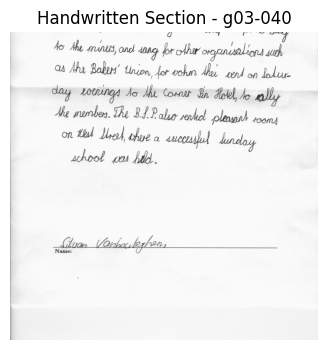


📄 Sample 2 - Form d03-117:
📝 Text: ': Sentence Database D03-117 A natural transition from gardens and orchards to th...'


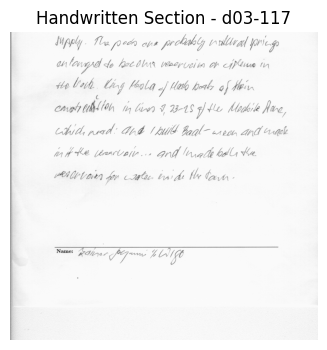

In [15]:
# --- Verify Dataset with Sample Display
def show_dataset_samples(dataset, num_samples=2):
    """Display sample handwritten images with transcriptions"""
    print(f"🔍 Showing {num_samples} dataset samples:")

    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        print(f"\n📄 Sample {i+1} - Form {sample['form_id']}:")
        print(f"📝 Text: '{sample['text'][:80]}...'")

        # Display handwritten section
        if os.path.exists(sample["image_path"]):
            image = Image.open(sample["image_path"])
            plt.figure(figsize=(12, 4))
            plt.imshow(image, cmap='gray')
            plt.title(f"Handwritten Section - {sample['form_id']}")
            plt.axis('off')
            plt.show()
        else:
            print("❌ Image not found")

# Show samples
if 'train_ds' in locals() and len(train_ds) > 0:
    show_dataset_samples(train_ds, 2)
else:
    print("❌ No dataset to display")


In [16]:
# --- Data Collator for Forms
def collate_fn(batch):
    """Process images and texts for training"""
    imgs = []
    texts = []

    # Process each item in batch
    for item in batch:
        try:
            img = Image.open(item["image_path"]).convert("RGB")
            imgs.append(img)
            texts.append(item["text"])
        except Exception as e:
            print(f"⚠️ Skipping item: {e}")
            continue

    if not imgs:
        return None

    # Process with TrOCR processor
    pixel_vals = processor(images=imgs, return_tensors="pt", padding=True).pixel_values
    labels = tokenizer(texts, padding="longest", truncation=True, return_tensors="pt", max_length=256).input_ids
    labels[labels == tokenizer.pad_token_id] = -100

    return {
        "pixel_values": pixel_vals,
        "labels": labels
    }

print("✅ Data collator ready")


✅ Data collator ready


In [27]:
# --- Training Setup (Fixed Parameter Names)
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr_iam_forms",
    per_device_train_batch_size=2,    # Small batch for memory
    per_device_eval_batch_size=2,
    predict_with_generate=True,
    logging_steps=20,
    eval_steps=50,
    save_steps=100,
    eval_strategy="steps",            # Changed from evaluation_strategy
    save_strategy="steps",
    num_train_epochs=2,               # Start with 2 epochs
    fp16=True,
    learning_rate=5e-5,
    remove_unused_columns=False,
    report_to="none",
    load_best_model_at_end=True,
    dataloader_drop_last=True
)

# Setup trainer
if 'train_ds' in locals() and len(train_ds) > 0:
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        data_collator=collate_fn,
        tokenizer=tokenizer,
    )
    print("✅ Trainer setup complete!")
else:
    print("❌ Cannot setup trainer - no dataset available")
    print("🔧 Make sure you've created the dataset first!")


✅ Trainer setup complete!


/tmp/ipython-input-1895399833.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [29]:
# --- Fix TrOCR Configuration Issue
# Set decoder_start_token_id to resolve training error
if hasattr(model.config, 'decoder_start_token_id'):
    if model.config.decoder_start_token_id is None:
        model.config.decoder_start_token_id = tokenizer.bos_token_id
        print(f"✅ Set decoder_start_token_id to: {model.config.decoder_start_token_id}")
else:
    model.config.decoder_start_token_id = tokenizer.bos_token_id
    print(f"✅ Added decoder_start_token_id: {model.config.decoder_start_token_id}")

# Also ensure generation config is aligned
if hasattr(model, 'generation_config'):
    model.generation_config.decoder_start_token_id = model.config.decoder_start_token_id
    print("✅ Generation config updated")

# Verify all token IDs are properly set
print(f"📋 Token Configuration:")
print(f"  BOS token ID: {tokenizer.bos_token_id}")
print(f"  EOS token ID: {tokenizer.eos_token_id}")
print(f"  PAD token ID: {tokenizer.pad_token_id}")
print(f"  Decoder start token ID: {model.config.decoder_start_token_id}")


✅ Set decoder_start_token_id to: 0
✅ Generation config updated
📋 Token Configuration:
  BOS token ID: 0
  EOS token ID: 2
  PAD token ID: 1
  Decoder start token ID: 0


In [30]:
# --- Start Training
if 'trainer' in locals():
    print("🎯 Starting training...")
    try:
        trainer.train()
        print("✅ Training completed!")

        # Save model
        trainer.save_model("./trocr_iam_forms")
        print("💾 Model saved!")

    except Exception as e:
        print(f"❌ Training error: {e}")
        print("💡 Try reducing batch size if you get memory errors")
else:
    print("❌ Trainer not available")


🎯 Starting training...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


✅ Training completed!
💾 Model saved!


In [32]:
# --- Fixed Test Model Inference
model.eval()

def test_ocr_inference(image_path):
    """Test OCR on a handwritten image"""
    try:
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=[image], return_tensors="pt").pixel_values.to(device)

        with torch.no_grad():
            # Fix: Use keyword argument instead of positional
            outputs = model.generate(
                pixel_values=pixel_values,  # Use keyword argument
                max_length=256,
                num_beams=4,
                early_stopping=True
            )

        predicted_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        return predicted_text
    except Exception as e:
        print(f"❌ Inference error: {e}")
        return ""

print("✅ Fixed inference function ready!")


✅ Fixed inference function ready!


In [33]:
# --- Test the Fixed Inference
# First, make sure you have evaluation data
if 'eval_ds' in locals() and len(eval_ds) > 0:
    print("🧪 Testing trained model:")

    # Test on first few samples
    for i in range(min(3, len(eval_ds))):
        sample = eval_ds[i]
        predicted = test_ocr_inference(sample["image_path"])

        print(f"\n📄 Sample {i+1}:")
        print(f"📝 Actual:    '{sample['text'][:80]}...'")
        print(f"🎯 Predicted: '{predicted}'")

        # Calculate rough accuracy
        actual_words = sample['text'].split()[:10]  # First 10 words
        predicted_words = predicted.split()[:10]
        matches = sum(1 for a, p in zip(actual_words, predicted_words) if a.lower() == p.lower())
        accuracy = matches / len(actual_words) * 100 if actual_words else 0
        print(f"📊 Word accuracy (first 10 words): {accuracy:.1f}%")
else:
    print("❌ No evaluation data - please run dataset creation first")


🧪 Testing trained model:

📄 Sample 1:
📝 Actual:    'Sentence Database L01-119 , One day Fred met Nick at the front door as they were...'
🎯 Predicted: '0 0000'
📊 Word accuracy (first 10 words): 0.0%

📄 Sample 2:
📝 Actual:    'Sentence Database L04-000 *Well, what do you think?’ she scoffed, her brilliant ...'
🎯 Predicted: 'Not logged inTalkContributionsCreate accountLog in'
📊 Word accuracy (first 10 words): 0.0%

📄 Sample 3:
📝 Actual:    'Sentence Database A06-152 Behind Bonn’s slogan of German self-determination is t...'
🎯 Predicted: '0 0'
📊 Word accuracy (first 10 words): 0.0%
